# Think Bayes solutions: Chapter 4

This notebook presents solutions to exercises in Think Bayes.

Copyright 2016 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT

In [4]:
from __future__ import print_function, division

import numpy as np

import thinkbayes2
from thinkbayes2 import Pmf, Cdf, Suite
import thinkplot

% matplotlib inline

## The Euro problem

Here's a class that represents hypotheses about the probability a coin lands heads.

In [5]:
class Euro(Suite):

    def Likelihood(self, data, hypo):
        """Computes the likelihood of `data` given `hypo`.
        
        data: string 'H' or 'T'
        hypo: probability of heads, 0-100
        
        returns: float
        """
        x = hypo
        if data == 'H':
            return x/100
        else:
            return 1 - x/100

We can make a uniform prior and update it with 140 heads and 110 tails:

In [6]:
suite = Euro(range(0, 101))
dataset = 'H' * 140 + 'T' * 110

for data in dataset:
    suite.Update(data)

And here's what the posterior looks like.

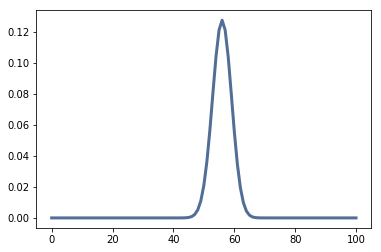

In [7]:
thinkplot.Pdf(suite)

We can summarize the posterior several ways, including the mean:

In [8]:
suite.Mean()

55.952380952380956

Median:

In [9]:
suite.Percentile(50)

56

The peak of the posterior, known as the Maximum Aposteori Probability (MAP)

In [10]:
suite.MAP()

56

And a 90% credible interval

In [11]:
suite.CredibleInterval(90)

(51, 61)

We can look up a particular value in the posterior PMF, but the result doesn't mean much, because we could have divided the range (0-100) into as many pieces as we like, and the result would be different.

In [12]:
suite.Prob(50)

0.02097652612954468

## Different priors

Let's see how that looks with different priors.

Here's a function that makes a uniform prior:

In [13]:
def UniformPrior(label='uniform'):
    """Makes a Suite with a uniform prior."""
    suite = Euro(range(0, 101), label=label)
    return suite

And another that makes a triangular prior.

In [14]:
def TrianglePrior(label='triangle'):
    """Makes a Suite with a triangle prior."""
    suite = Euro(label=label)
    for x in range(0, 51):
        suite[x] = x
    for x in range(51, 101):
        suite[x] = 100-x 
    suite.Normalize()
    return suite

Here's what they look like:

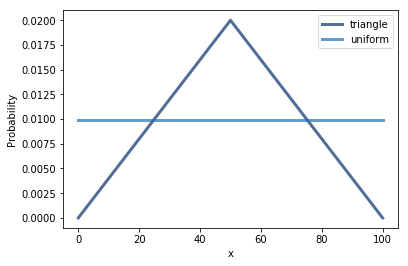

In [15]:
triangle = TrianglePrior()
uniform = UniformPrior()
suites = [triangle, uniform]

thinkplot.Pdfs(suites)
thinkplot.Config(xlabel='x', ylabel='Probability')

If we update them both with the same data:

In [16]:
def RunUpdate(suite, heads=140, tails=110):
    """Updates the Suite with the given number of heads and tails.

    suite: Suite object
    heads: int
    tails: int
    """
    dataset = 'H' * heads + 'T' * tails
    for data in dataset:
        suite.Update(data)

In [17]:
for suite in suites:
    RunUpdate(suite)

The results are almost identical; the remaining difference is unlikely to matter in practice.

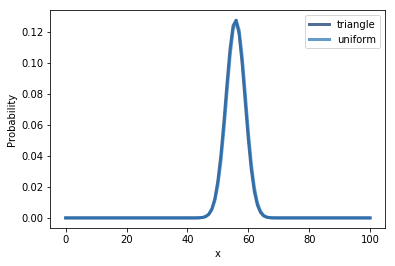

In [18]:
thinkplot.Pdfs(suites)
thinkplot.Config(xlabel='x', ylabel='Probability')

## The binomial likelihood function

We can make the Euro class more efficient by computing the likelihood of the entire dataset at once, rather than one coin toss at a time.

If the probability of heads is p, we can compute the probability of k=140 heads in n=250 tosses using the binomial PMF.

In [19]:
class Euro2(thinkbayes2.Suite):
    """Represents hypotheses about the probability of heads."""

    def Likelihood(self, data, hypo):
        """Computes the likelihood of the data under the hypothesis.

        hypo: integer value of x, the probability of heads (0-100)
        data: tuple of (number of heads, number of tails)
        """
        x = hypo / 100.0
        heads, tails = data
        like = x**heads * (1-x)**tails
        return like

I left out the binomial coefficient ${n}\choose{k}$ because it does not depend on `p`, so it's the same for all hypotheses.  

In [22]:
suite = Euro2(range(0, 101))
dataset = 140, 110
suite.Update(dataset)

2.6088321798736822e-76

Here's what the posterior looks like.

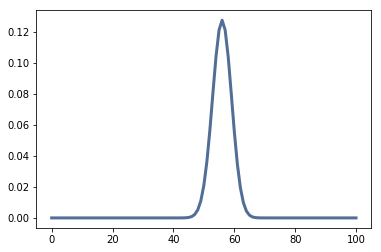

In [23]:
thinkplot.Pdf(suite)

## The Beta distribution

The Beta distribution is a conjugate prior for the binomial likelihood function, which means that if you start with a Beta distribution and update with a binomial likelihood, the posterior is also Beta.

Also, given the parameters of the prior and the data, we can compute the parameters of the posterior directly.  The following class represents a Beta distribution and provides a constant-time Update method.

In [24]:
from scipy import special

class Beta:
    """Represents a Beta distribution.

    See http://en.wikipedia.org/wiki/Beta_distribution
    """
    def __init__(self, alpha=1, beta=1, label=None):
        """Initializes a Beta distribution."""
        self.alpha = alpha
        self.beta = beta
        self.label = label if label is not None else '_nolegend_'

    def Update(self, data):
        """Updates a Beta distribution.

        data: pair of int (heads, tails)
        """
        heads, tails = data
        self.alpha += heads
        self.beta += tails

    def Mean(self):
        """Computes the mean of this distribution."""
        return self.alpha / (self.alpha + self.beta)

    def MAP(self):
        """Computes the value with maximum a posteori probability."""
        a = self.alpha - 1
        b = self.beta - 1
        return a / (a + b)

    def Random(self):
        """Generates a random variate from this distribution."""
        return random.betavariate(self.alpha, self.beta)

    def Sample(self, n):
        """Generates a random sample from this distribution.

        n: int sample size
        """
        size = n,
        return np.random.beta(self.alpha, self.beta, size)

    def EvalPdf(self, x):
        """Evaluates the PDF at x."""
        return x ** (self.alpha - 1) * (1 - x) ** (self.beta - 1)

    def MakePmf(self, steps=101, label=None):
        """Returns a Pmf of this distribution.

        Note: Normally, we just evaluate the PDF at a sequence
        of points and treat the probability density as a probability
        mass.

        But if alpha or beta is less than one, we have to be
        more careful because the PDF goes to infinity at x=0
        and x=1.  In that case we evaluate the CDF and compute
        differences.

        The result is a little funny, because the values at 0 and 1
        are not symmetric.  Nevertheless, it is a reasonable discrete
        model of the continuous distribution, and behaves well as
        the number of values increases.
        """
        if label is None and self.label is not None:
            label = self.label

        if self.alpha < 1 or self.beta < 1:
            cdf = self.MakeCdf()
            pmf = cdf.MakePmf()
            return pmf

        xs = [i / (steps - 1) for i in range(steps)]
        probs = [self.EvalPdf(x) for x in xs]
        pmf = Pmf(dict(zip(xs, probs)), label=label)
        return pmf

    def MakeCdf(self, steps=101):
        """Returns the CDF of this distribution."""
        xs = [i / (steps - 1) for i in range(steps)]
        ps = special.betainc(self.alpha, self.beta, xs)
        cdf = Cdf(xs, ps)
        return cdf

    def Percentile(self, ps):
        """Returns the given percentiles from this distribution.

        ps: scalar, array, or list of [0-100]
        """
        ps = np.asarray(ps) / 100
        xs = special.betaincinv(self.alpha, self.beta, ps)
        return xs


Here's how we use it.

In [25]:
beta = Beta()
beta.Update((140, 110))
beta.Mean()

0.5595238095238095

And here's the posterior.

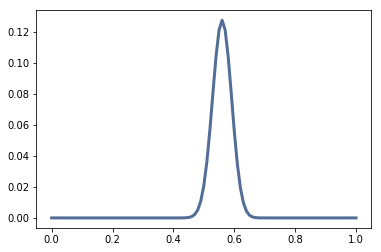

In [26]:
thinkplot.Pdf(beta.MakePmf())

Amazing, no?

**Exercise:** One way to construct priors is to make a Beta distribution and adjust the parameters until it has the shape you want.  Then when you do an update, the data get added to the parameters of the prior.  Since the parameters of the prior play the same mathematical role as the data, they are sometimes called "precounts".

Suppose you believe that most coins are fair or unlikely to deviate from 50% by more than a few percentage points.  Construct a prior that captures this belief and update it with the Euro data.  How much effect does it have on the posterior, compared to the uniform prior?

Hint: A Beta distribution with parameters `(1, 1)` is uniform from 0 to 1.

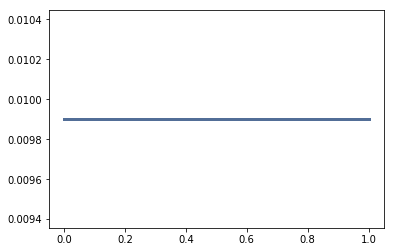

In [27]:
# Solution

# Here's the uniform prior
    
uniform = Beta(1, 1, label='uniform')
thinkplot.Pdf(uniform.MakePmf())

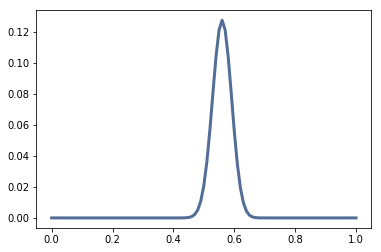

In [28]:
# Solution

# And here's what it looks like after the update
    
uniform.Update(dataset)
thinkplot.Pdf(beta.MakePmf())

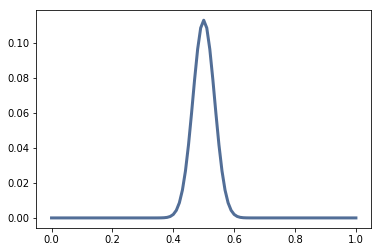

In [29]:
# Solution

# Here's a beta prior with precounts chosen to represent
# out background knowledge about coins.
    
beta = Beta(100, 100, label='beta')
thinkplot.Pdf(beta.MakePmf())

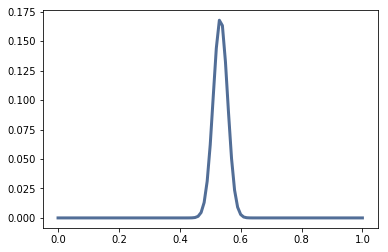

In [30]:
# Solution

# And here's what it looks like after the update
    
beta.Update(dataset)
thinkplot.Pdf(beta.MakePmf())

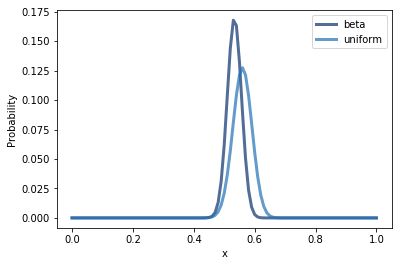

In [31]:
# Solution

# Comparing the two, we see that the (more) informative
# prior influences the location and spread of the
# posterior.
    
thinkplot.Pdf(beta.MakePmf())
thinkplot.Pdf(uniform.MakePmf())
thinkplot.Config(xlabel='x', ylabel='Probability')

**Exercise:**  At the 2016 Summer Olympics in the Women's Skeet event, Kim Rhode faced Wei Meng in the bronze medal match.  They each hit 15 of 25 skeets, sending the match into sudden death.  In the first round, both hit 1 of 2 skeets.  In the next two rounds, they each hit 2 skeets.  Finally, in the fourth round, Rhode hit 2 and Wei hit 1, so Rhode won the bronze medal, making her the first Summer Olympian to win an individual medal at six consecutive summer games.

But after all that shooting, what is the probability that Rhode is actually a better shooter than Wei?  If the same match were held again, what is the probability that Rhode would win?

As always, you will have to make some modeling decisions, but one approach is to estimate, for each shooter, the probability of hitting a skeet.  Then, to estimate the probability that Rhode is a better shooter, you can draw samples from the two posterior distributions and compare them.  To estimate the probability of winning a rematch, you could draw samples from the posterior distributions and simulate a round of 25 shots.

In [32]:
# Solution

# Here's a Beta distribution that represents Rhode's probability
# of hitting a skeet

rhode = Beta(1, 1, label='Rhode')
rhode.Update((22, 11))

In [33]:
# Solution

# And another Beta for Wei

wei = Beta(1, 1, label='Wei')
wei.Update((21, 12))

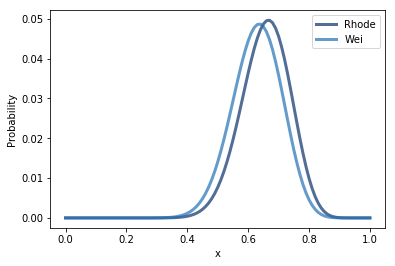

In [34]:
# Solution

# Here's what the posteriors look like

thinkplot.Pdf(rhode.MakePmf())
thinkplot.Pdf(wei.MakePmf())
thinkplot.Config(xlabel='x', ylabel='Probability')

In [35]:
# Solution

# To estimate the probability of superiority, we can
# draw samples from the posteriors and compare them

rhode_sample = rhode.MakeCdf(10001).Sample(10000)
wei_sample = wei.MakeCdf(10001).Sample(10000)
np.mean(rhode_sample > wei_sample)

0.6056

In [36]:
# Solution

# The probability that Rhode is a better shooter is about 59%

np.mean(rhode_sample < wei_sample)

0.3938

In [37]:
rhode_sample

array([0.5827, 0.6242, 0.5319, ..., 0.5606, 0.6851, 0.7526])

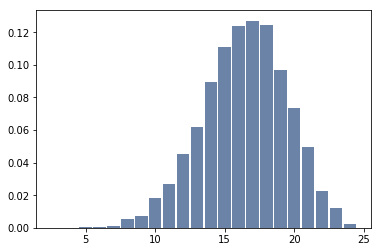

In [38]:
# Solution

# To simulate a rematch, we can draw `p` from the posterior
# distribution and then sample from a binomial distribution
# with parameters `p` and `n=25`.

rhode_rematch = np.random.binomial(25, rhode_sample)
thinkplot.Hist(Pmf(rhode_rematch))

In [33]:
# Solution

# The probability that Rhode wins a rematch (without going
# to sudden death) is about 52%

wei_rematch = np.random.binomial(25, wei_sample)
np.mean(rhode_rematch > wei_rematch)

0.52090000000000003

In [34]:
# Solution

# The probability that Wei wins the rematch is 39%

np.mean(rhode_rematch < wei_rematch)

0.39079999999999998

In [35]:
# Solution

# And the chance that the rematch also goes to sudden death is
# about 9%

# Assuming that sudden death is close to 50/50, the overall chance
# that Rhode winds is about 56%

np.mean(rhode_rematch == wei_rematch)

0.088300000000000003

**Exercise** Suppose that instead of observing coin tosses directly, you measure the outcome using an instrument that is not always correct. Specifically, suppose there is a probability `y` that an actual heads is reported as tails, or actual tails reported as heads.

Write a class that estimates the bias of a coin given a series of outcomes and the value of `y`.

How does the spread of the posterior distribution depend on `y`?

In [36]:
# Solution

# Here's a class that models an unreliable coin

class UnreliableCoin(Suite):
    
    def __init__(self, prior, y):
        """
        prior: seq or map
        y: probability of accurate measurement
        """
        Suite.__init__(self, prior)
        self.y = y
    
    def Likelihood(self, data, hypo):
        """
        data: outcome of unreliable measurement, either 'H' or 'T'
        hypo: probability of heads, 0-100
        """
        x = hypo / 100
        y = self.y
        if data == 'H':
            return x*y + (1-x)*(1-y)
        else:
            return x*(1-y) + (1-x)*y

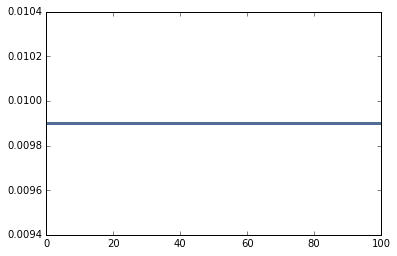

In [37]:
# Solution

# Now let's initialize one with `y=0.9`:

prior = range(0, 101)
suite = UnreliableCoin(prior, y=0.9)
thinkplot.Pdf(suite)

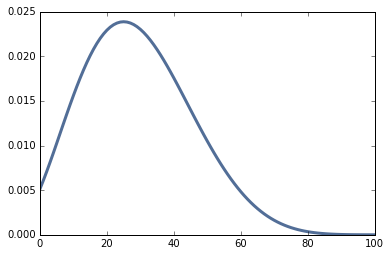

In [38]:
# Solution

# And update with 3 heads and 7 tails.

for outcome in 'HHHTTTTTTT':
    suite.Update(outcome)
    
thinkplot.Pdf(suite)

In [39]:
# Solution

# Now let's try it out with different values of `y`:

def compute_prior(y):
    prior = range(0, 101)
    suite = UnreliableCoin(prior, y=y)
    for outcome in 'HHHTTTTTTT':
        suite.Update(outcome)
    
    thinkplot.Pdf(suite, label='y=%g' % y)

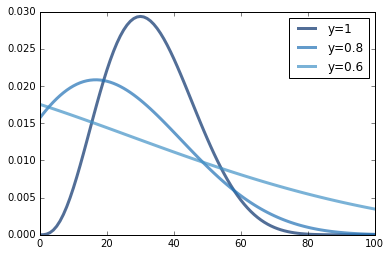

In [40]:
# Solution

# The posterior distribution gets wider as the measurement gets less reliable.

compute_prior(1)
compute_prior(0.8)
compute_prior(0.6)
thinkplot.config(legend=True)

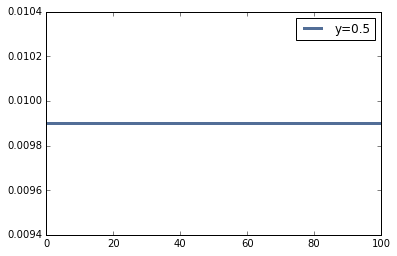

In [41]:
# Solution

# At `y=0.5`, the measurement provides no information, so the posterior equals the prior:

compute_prior(0.5)
thinkplot.config(legend=True)

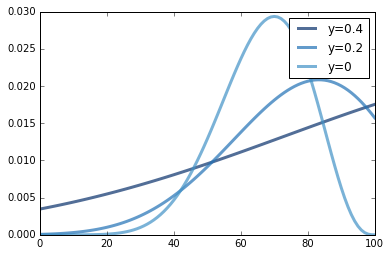

In [42]:
# Solution

# As the coin gets less reliable (below `y=0.5`) the distribution gets narrower again.  
# In fact, a measurement with `y=0` is just as good as one with `y=1`, 
# provided that we know what `y` is.

compute_prior(0.4)
compute_prior(0.2)
compute_prior(0.0)
thinkplot.config(legend=True)

**Exercise** This exercise is inspired by a question posted by a “redditor” named dominosci on Reddit’s statistics “subreddit” at http://reddit.com/r/statistics.

Reddit is an online forum with many interest groups called subreddits. Users, called redditors, post links to online content and other web pages. Other redditors vote on the links, giving an “upvote” to high-quality links and a “downvote” to links that are bad or irrelevant.

A problem, identified by dominosci, is that some redditors are more reliable than others, and Reddit does not take this into account.

The challenge is to devise a system so that when a redditor casts a vote, the estimated quality of the link is updated in accordance with the reliability of the redditor, and the estimated reliability of the redditor is updated in accordance with the quality of the link.

One approach is to model the quality of the link as the probability of garnering an upvote, and to model the reliability of the redditor as the probability of correctly giving an upvote to a high-quality item.

Write class definitions for redditors and links and an update function that updates both objects whenever a redditor casts a vote.

In [43]:
# Solution

# Here's one possible model:

#  Each article has a quality Q, which is the probability of 
#  eliciting an upvote from a completely reliab;e redditor. 

#  Each user has a reliability R, which is the probability of
#  giving an upvote to an item with Q=1.

#  The probability that a redditor with reliability R gives an
#  upvote to an item with quality Q is `R*Q + (1-R) * (1-Q)`

# Now when a redditor votes on a item, we simultaneously update our
# belief about the redditor and the item.

class Redditor(Suite):
    """Represents hypotheses about the trustworthiness of a redditor."""

    def Likelihood(self, data, hypo):
        """Computes the likelihood of the data under the hypothesis.

        hypo: integer value of r, the prob of a correct vote (0-100)
        data: (vote, q) pair, where vote is 'up' or 'down' and
              q is the mean quality of the link
        """
        r = hypo / 100.0
        vote, q = data

        if vote == 'up':
            return r * q + (1-r) * (1-q)
        elif vote == 'down':
            return r * (1-q) + (1-r) * q
        else:
            return 0

In [44]:
# Solution
    
class Item(Suite):
    """Represents hypotheses about the quality of an item."""

    def Likelihood(self, data, hypo):
        """Computes the likelihood of the data under the hypothesis.

        hypo: integer value of x, the prob of garnering an upvote
        data: (vote, t) pair, where vote is 'up' or 'down' and
              t is the mean trustworthiness of the redditor
        """
        x = hypo / 100.0
        vote, r = data

        if vote == 'up':
            return x * r + (1-x) * (1-r)
        elif vote == 'down':
            return x * (1-r) + (1-x) * r
        else:
            return 0

0.6699999999999996

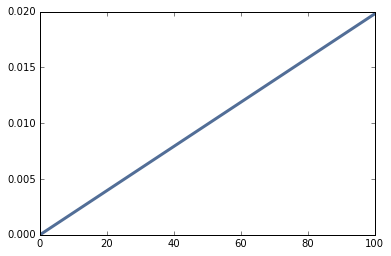

In [45]:
# Solution
    
# Suppose we start with a redditor who has demonstrated some reliability.

from thinkbayes2 import Beta

redditor = Redditor(label='redditor')
beta = Beta(2, 1)
for val, prob in beta.MakePmf().Items():
    redditor.Set(val*100, prob)
    
thinkplot.Pdf(redditor)
mean_r = redditor.Mean() / 100.0
mean_r

0.5000000000000001

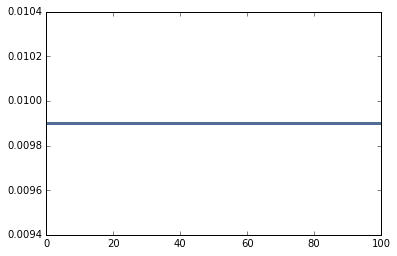

In [46]:
# Solution
    
# And a completely unknown item.

item = Item(range(0, 101), label='item')

thinkplot.Pdf(item)
mean_q = item.Mean() / 100.0
mean_q

In [47]:
# Solution
    
# We update the priors simultaneously, each using the mean value of the other.

redditor.Update(('up', mean_q))
item.Update(('up', mean_r))

0.4999999999999999

67.0 (22.0, 98.0)


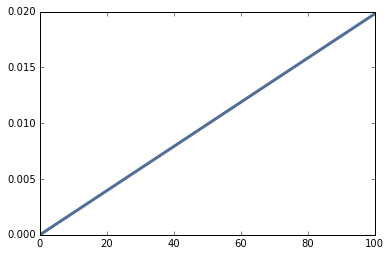

In [48]:
# Solution
    
# And here are the results.  Since we knew nothing about the item,
# the vote provides no information about the redditor:

thinkplot.Pdf(redditor)
print(redditor.Mean(), redditor.CredibleInterval(90))

55.78 (7, 97)


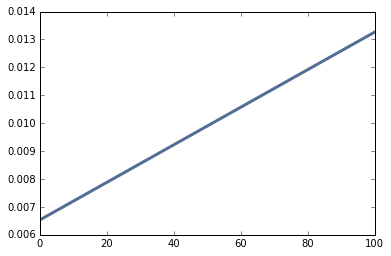

In [49]:
# Solution
    
# But since we think the redditor is reliable, the vote provides 
# some information about the item:

thinkplot.Pdf(item)
print(item.Mean(), item.CredibleInterval(90))

In [50]:
# Solution
    
# After the upvote, the mean quality of the item increases to about 56%.

# The model I used to compute likelihoods is not the only choice.
# As an alternative, I could have used something like 
# item response theory (https://en.wikipedia.org/wiki/Item_response_theory),
# which we'll see in Chapter 12.